# Calculate Dye Dispersion from LES

In this notebook I load the 3 numerical model runs and calculate the dye dispersion

I follow the method of M. Sundermeyer (used for the observational analysis).
This involves first calculating the 2nd moments at each depth, then averaging over $\pm 2$ std. deviations from the vertical COM.

This is described in the supplementary material of Wenegrat et al. 2020

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
COM Statistics

Created on Mon Mar 26 09:44:57 2018

@author: jacob
"""

import numpy as np
import h5py
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import scipy.stats as stats
from astropy.stats import circstats

In [157]:
#%% LOAD
# This function does the calculation for a given model run (filename)
def loadKappa(filename):
    f = h5py.File(filename, 'r')

    # List all groups
#    print("Keys: %s" % f.keys())
#    keys = list(f.keys())[:]
    
    
    dye1 = f['dye1'] # dye 1 is the 25 m release, dye2 was deeper (50 m)

    time = f['t'][:,0]
    x = f['x'][:,0]
    z = f['z'][:,0]
    z = z[1:]
    
    dye1 = dye1[:,1:,:]
    nt, nz, nx = dye1.shape
    
    # COM Calcs    
    # define circular coordinate system for averaging
    theta = x/np.max(x)*2*np.pi
    xi = np.cos(theta)
    zi = np.sin(theta)
    x2i = np.cos(2*theta)
    z2i = np.sin(2*theta)
    
    # Pick which variable to use
    dyevar = dye1
    
    # Pre-allocate
    ZCM = np.zeros((nt,))
    xposcom = np.zeros((nt,))
    xs = np.zeros((nt, nx))
    XVar = np.zeros((nt,nz))
    
    dyehor = np.zeros((nt, nz))
    
    # For each depth and timestep calculate the 2nd moment
    for j in range(0, nz):
        print(j)
        for i in range(0,nt):
            dyehor[i, j] = integrate.trapz(dyevar[i,j,:], x=x) # integrate horizontally at each depth for later vert COM calc
            # Calculate zonal center of mass
            xii = xi*dyevar[i,j,:] #Weighted unwrapped coordinate system
            zii = zi*dyevar[i,j,:]
            tbar = np.arctan2(-np.mean(zii), -np.mean(xii)) + np.pi 
#            vbar = np.arctan2(-np.mean(z2i*dyevar[i,j,:]), -np.mean(x2i*dyevar[i,j,:])) + np.pi
            ZCM[i] = np.max(x)*tbar/(2*np.pi) # This is the horizontal (zonal) COM
            
            # Find index of Zonal Center of Mass
            ind = np.where(x>=ZCM[i])[0][0]
            xposcom[i] = x[ind]
            indshift = ind-nx/2 # This is used to center the dye in the domain.
            indshift = indshift.astype('int64')
            
            #Circular shift everything
            dyeroll = np.roll(dyevar[i,j,:], -indshift, axis=0) # This puts the COM in the center of the domain
#            xroll = np.roll(x, -indshift)
            xs = x - x[int(nx/2)] # Set center coordinate to 0

            
            # Calculate dye variance around COM
            M20 = integrate.trapz(xs**2*dyeroll, x=xs, axis=0) #
            XVar[i,j] = M20/dyehor[i,j] 
           
            #dyenorm = dyevar[i,j,:]/np.max(dyevar[i,j,:])
            #XVar[i,j] = stats.circvar(np.arctan2(-zi*dyenorm, -xi*dyenorm))*np.max(x)**2/(2*np.pi)**2
    #        XVar[i,j] = circstats.circvar(theta, weights = dyevar[i,j,:]/np.sum(dyevar[i,j,:]))*np.max(x)**2/(2*np.pi)**2
            #test = circstats.circmoment(theta, p=2.0,centered=False, weights = dyevar[i,j,:]/dyehor[i,j])
            #XVar[i,j] = test[0]*np.max(x)**2

    # Now calculate the vertical COM at each timestep
    VCMind = np.zeros((nt,))
    Vsigma = np.zeros((nt,))
    ZCOM = np.zeros((nt,))
    for i in range(0, nt):
       VCOM = integrate.trapz(z*dyehor[i,:], x=z)/integrate.trapz(dyehor[i,:], x=z) # restrict z coordinate
       ind = np.argmin(np.abs(z-VCOM))
       if not ind==0:
           VCMind[i] = np.where(z>=VCOM)[0][0]
           ZCOM[i] = z[int(VCMind[i])]
           zs = z - z[int(VCMind[i])]
           Vsigma[i] = integrate.trapz(zs**2*dyehor[i,:], x=zs)/integrate.trapz(dyehor[i,:], x=zs)
       
              
    # Calculate kappa and buoyancy class
    mask = (np.zeros((nt,nz)))
    zu = np.zeros((nt,))
    zd = np.zeros((nt,))
    zdiff = np.zeros((nt,))
    
    indz = np.argmin(np.abs(z+0))
    for i in range(0, nt):
        # 2 sigma method a la Miles
        indu = np.argmin(np.abs(z - (ZCOM[i] + 2*Vsigma[i]**(1/2)))) # 2 std devs above the vertical COM
        if indu>indz: 
            indu = indz
        indd = np.argmin(np.abs(z - (ZCOM[i] - 2*Vsigma[i]**(1/2)))) # 2 std devs below the vertical COM
        
        zu[i] = z[indu]
        zd[i] = z[indd]
        zdiff[i] = z[indu] - z[indd]
        mask[i,indd:indu] = 1 # Note that the mask is size (nt, nz)

    # Concentration weighted vertical average of the X 2nd mometn
    XVarB = integrate.trapz(XVar*mask*dyehor, x=z, axis=-1)/(integrate.trapz(dyehor*mask, x=z, axis=-1))
    
    #XVarB = integrate.trapz(XVar*mask, x=z, axis=-1)/(np.abs(zdiff))
    
    # Horizontal diffusivity
    kappa = 0.5*np.gradient(XVarB[0:time.size], axis=0)/np.gradient(time)
    # Vertical diffusivity
    kappaz = 0.5*np.gradient(Vsigma[0:time.size], axis=0)/np.gradient(time)
    return kappa, kappaz, XVarB, time

In [158]:
#%% 
    kappa_front, kappaz_front, Var_front, time_front = loadKappa('/data/pacific/jacob/LATMIXDYE/LATMIX/run10k.mat') # Pick which run
    kappa_nofront, kappaz_nofront, Var_nofront, time_nofront = loadKappa('/data/pacific/jacob/LATMIXDYE/nofront.mat') # Pick which run
    kappa_nogeo, kappaz_nogeo, Var_nogeo, time_nogeo = loadKappa('/data/pacific/jacob/LATMIXDYE/notw.mat') # Pick which run
#%%

0


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


In [156]:
timevar = time_nogeo
kappaz = kappa_nogeo

indl = np.argmin(np.abs(timevar/86400+64.5 - 64.875))
indr = np.argmin(np.abs(timevar/86400+64.5 - (65.5)))

pstargrad = 0.06/2.5e3
#pstargrad = 0.1/1e3
bld = 100

#avgkappa = np.mean(kappaz[indl:indr]) # Naive way to do it
avgkappa = integrate.trapz(kappaz[indl:indr], x=timevar[indl:indr])/(timevar[indr] - timevar[indl]) # account for variable timestep

peakkappa = np.nanmax(kappaz[indl:indr])
#kappasteady = avgkappa*5
#kappaoscill = avgkappa/5
#maxkappa = np.nanmax(kappaz)

print('K average: ' + str(avgkappa))
print('K peak:    ' + str(peakkappa))

#print('K steady: ' + str(kappasteady))
#print('K oscill: ' + str(kappaoscill))

#print('Averaged: ' + str(avgkappa*bld*pstargrad)) # estimating one event per 3 days
#print('Maximum:  ' + str(maxkappa*bld*pstargrad)) # estimating one event per 3 days

#print(0.5*(Var_nogeo[indr] - Var_nogeo[indl])/(timevar[indr] - timevar[indl]) )

K average: 8.366926543618627
K peak:    45.656025415069834
8.360095908499654


## Calculate Flux Estimates
Here we do the back of the envelope calculations for the salinity and P* fluxes

In [165]:
# Calculate salinity flux
###############
kappa_sal = 50 # What diffusivity to use
D = 100
DeltaS = -1
L = 10e3

LGulf = 1200e3 # Integrate over a portion of the Gulf Stream, here following Joyce et al. 2013

IntFlux = kappa_sal*D*DeltaS/L * LGulf # Units of m^2/s *  m * PSU/m * m = m^3 PSU/ s

print(f'ML Salinity Flux integrated over {LGulf/1e3} km: {IntFlux} psu m^3 s^{-1}')


# Calculate P* flux
kappa_p = 50
D = 100 
DeltaP = 0.06
L = 5e3

LGulf = 3000e3 # For comparison with Palter et al. 2011

IntPFlux = kappa_p*D*DeltaP/L * LGulf # units of m^2/s * m * mmol/m^3 m^{-1} * m = mmol/s
IntPFlux = IntPFlux * 365*86400/1000# units of mol/year
IntPFlux = IntPFlux * 0.5 # Conditions found 1/2 of the time
print(f'ML P* integrated over {LGulf/1e3} km: {IntPFlux} mol/year')



ML Salinity Flux integrated over 1200.0 km: -600000.0 psu m^3 s^-1
ML P* integrated over 3000.0 km: 2838240000.0 mol/year


## Make figure 5
This makes the figure of the increase of cross-frontal variance

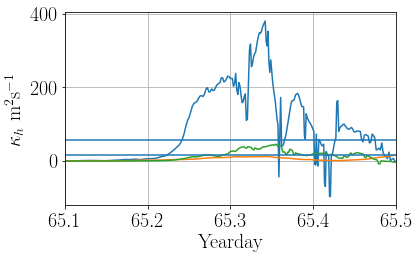

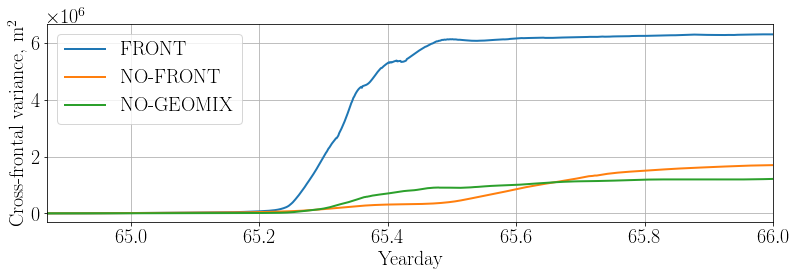

In [162]:
#%% PLOT KAPPA Z
plt.figure()
plt.plot(time_front/86400+64.5,kappa_front[0:time_front.size])
plt.plot(time_nofront/86400+64.5,kappa_nofront[0:time_nofront.size])
plt.plot(time_nogeo/86400+64.5,kappa_nogeo[0:time_nogeo.size])
#plt.axhline(57)
#plt.axhline(16)
plt.xlabel('Yearday')
plt.ylabel('$\kappa_h$ m$^2$s$^{-1}$')
plt.grid()
plt.tight_layout()
plt.xlim((65.1, 65.5))

#%% PLOT Variance
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 20
plt.rcParams['contour.negative_linestyle'] = 'solid'

plt.figure(figsize=(12,4))
plt.plot(time_front/86400+64.5,Var_front[0:time_front.size], label='FRONT', linewidth=2)
plt.plot(time_nofront/86400+64.5,Var_nofront[0:time_nofront.size], label='NO-FRONT', linewidth=2)
plt.plot(time_nogeo/86400+64.5,Var_nogeo[0:time_nogeo.size], label='NO-GEOMIX', linewidth=2)

plt.xlabel('Yearday')
plt.ylabel('Cross-frontal variance, m$^2$')
plt.grid()
plt.tight_layout()
plt.legend()
plt.xlim((64.87, 66))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#plt.savefig('/home/jacob/Dropbox/GulfStreamDye/LATMIXSCIENCE/FigureModelVariance.pdf', bbox_inches='tight')

## Extras

Some miscelleaneous stuff not used in the ms

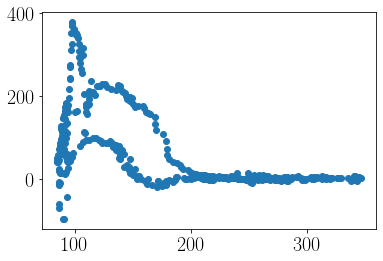

In [58]:
plt.scatter(np.gradient(time_front), kappa_front)

(64.5, 66)

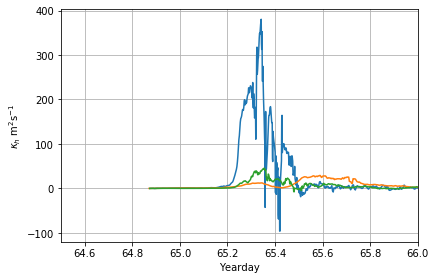

In [9]:
#%% PLOT KAPPA H
plt.figure()
plt.plot(time_front/86400+64.5,kappa_front[0:time_front.size])
plt.plot(time_nofront/86400+64.5,kappa_nofront[0:time_nofront.size])
plt.plot(time_nogeo/86400+64.5,kappa_nogeo[0:time_nogeo.size])

plt.xlabel('Yearday')
plt.ylabel('$\kappa_h$ m$^2$s$^{-1}$')
plt.grid()
plt.tight_layout()
plt.xlim((64.5, 66))

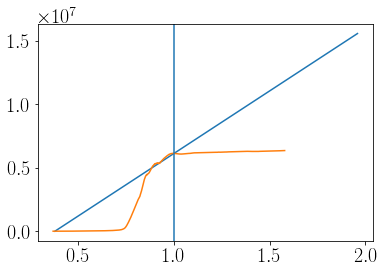

In [85]:
#%% DO SOME VALIDATION

xg = np.linspace(-20e3, 20e3, 1000)
#time = np.linspace(0, 10, 500)
time_syn = time_front +0.38*86400
dye = np.zeros((time.size, xg.size))

sigma2 = np.zeros((time_syn.size,))
sigma2[0] = 75**2
dye[0,:] = np.exp( -(xg**2/(2*25**2) ))

kap = 57
for i in range(1, time_syn.size):
    #kap = kappa_front[i]
    if ~np.isfinite(kap):
        kap = 0
    sigma2[i] = sigma2[i-1] + (time_syn[i] - time_syn[i-1])*2*kap
    dye[i,:] = np.exp( -(xg**2/(2*sigma2[i]) ))
#plt.figure()
#plt.plot(x, dye[0,:])
#tl = range(0, np.argmin(np.abs(time_front/86400-65.5+64.5)), 50)
#plt.plot(xg, np.transpose(dye[tl,:]))
#plt.legend()

plt.figure()
plt.plot(time_syn/86400, sigma2)
plt.plot(time_front/86400, Var_front[0:time_front.size])
plt.axvline(65.5-64.5)

In [153]:
(10e3)**2/10e6

10.0

In [81]:
#%% PICK A PARTICULAR TIME AND PLOT THE INTEGRATED DYE VARIANCE
# 1) Load a run
# 2) Pick a time
# 3) Calculate vertically integrated dye concentration
# 4) Compare it to the Gaussian shape inferred from above integration

f = h5py.File('/data/pacific/jacob/LATMIXDYE/LATMIX/run10k.mat', 'r')
dye1 = f['dye1']
time = f['t'][:,0]
x = f['x'][:,0]
z = f['z'][:,0]
z = z[1:]
dye1 = dye1[:,1:,:]
nt, nz, nx = dye1.shape

# COM Calcs    
# define circular coordinate system for averaging
theta = x/np.max(x)*2*np.pi
xi = np.cos(theta)
zi = np.sin(theta)
x2i = np.cos(2*theta)
z2i = np.sin(2*theta)

0.5999074074074074
0.6003640738512084


(-5000.0, 5000.0)

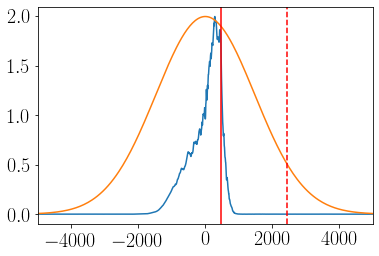

In [134]:
#%% CONTINUED...
#Pick a time
timetarget = 65.1

timeind = np.argmin(np.abs(time/86400+64.5-timetarget))
timeind_syn = np.argmin(np.abs(time_syn/86400 + 64.5 - timetarget))
dyevert = integrate.trapz(dye1[timeind,:,:], x=z, axis=0)

# Calculate zonal center of mass
xii = xi*dyevert #Weighted unwrapped coordinate system
zii = zi*dyevert
tbar = np.arctan2(-np.mean(zii), -np.mean(xii)) + np.pi
#            vbar = np.arctan2(-np.mean(z2i*dyevar[i,j,:]), -np.mean(x2i*dyevar[i,j,:])) + np.pi
ZCM = np.max(x)*tbar/(2*np.pi) # This is the horizontal (zonal) COM
            
 # Find index of Zonal Center of Mass
ind = np.where(x>=ZCM)[0][0]
xposcom = x[ind]
indshift = ind-nx/2 # This is used to center the dye in the domain.
indshift = indshift.astype('int64')
            
            #Circular shfit everything
dyeroll = np.roll(dyevert, -indshift, axis=0) # This puts the COM in the center of the domain
#            xroll = np.roll(x, -indshift)
xs = x - x[int(nx/2)] # Set center coordinate to 0


vsig = integrate.trapz(xs**2*dyeroll, x=xs)/integrate.trapz(dyeroll, x=xs)
plt.figure()
plt.plot(xs, dyeroll)
plt.plot(xg, dye[timeind_syn,:]*np.max(dyeroll)/np.max(dye[timeind_syn,:]))
plt.axvline(np.sqrt(vsig), color='r')
plt.axvline(np.sqrt(sigma2[timeind]), color='r', linestyle='dashed')

print(time_syn[timeind_syn]/86400)
print(time[timeind]/86400)

plt.xlim(-5e3, 5e3)

In [136]:
# Confirm that the rolled dye COM is at x=0.
# Calculate zonal center of mass
xii = xi*dyeroll #Weighted unwrapped coordinate system
zii = zi*dyeroll
tbar = np.arctan2(-np.mean(zii), -np.mean(xii)) + np.pi
#            vbar = np.arctan2(-np.mean(z2i*dyevar[i,j,:]), -np.mean(x2i*dyevar[i,j,:])) + np.pi
ZCM = np.max(x)*tbar/(2*np.pi) # This is the horizontal (zonal) COM
            
 # Find index of Zonal Center of Mass
ind = np.where(x>=ZCM)[0][0]
print(x[ind])
ZCM # NOTE THIS SHOULD BE 5km

5003.90625


5003.330231031377

In [101]:
    #%% PLOT VARIANCE
plt.figure()
plt.plot(time/86400+64.5,4*np.sqrt(XVarB[0:time.size]))
plt.xlabel('Yearday')
plt.ylabel('4$\sigma$ [m]')
plt.grid()
plt.tight_layout()
plt.xlim((64.5, 66))
#%%

plt.figure()
plt.pcolor(time/86400,z, np.transpose(kappa), vmin=0, vmax=500)
plt.colorbar()
plt.plot(time/86400, ZCOM[0:1569])

#%%
plt.figure()
plt.pcolor(time/86400 +64.5,z, np.transpose(XVar[0:1569,:]*mask[0:1569,:]))
plt.colorbar()
plt.plot(time/86400 + 64.5, ZCOM[0:1569])
plt.plot(time/86400 + 64.5, zd[0:1569])
plt.plot(time/86400 + 64.5, zu[0:1569])
plt.xlabel('Yearday')
plt.xlim((64.5, 66))
plt.ylabel('z')
#%%
plt.figure()
plt.pcolor(time/86400+64.5,z, np.transpose(dyehor[0:1569,:]))

NameError: name 'XVarB' is not defined

<Figure size 432x288 with 0 Axes>

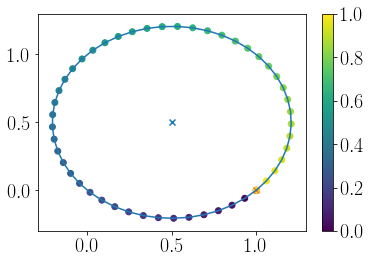

In [150]:
## Quick Check of Analytical solution:

ta = np.linspace(0, 2*np.pi)

ueq = -1/2
ug = 1
veq = 1/2
vg = 0

ut = ug - veq*np.sin(ta) + ueq*(1-np.cos(ta))
vt = veq*(1-np.cos(ta)) +ueq*np.sin(ta)

plt.plot(ut, vt)
plt.scatter(ut, vt, c=ta)
plt.scatter(ug+ueq, veq, marker='x')
plt.scatter(ug, 0, marker='x')
plt.colorbar()
